## Code: https://github.com/hunkim/PyTorchZeroToAll
## Slides: http://bit.ly/PyTorchZeroAll
## Videos: http://bit.ly/PyTorchVideo

## Sigmoid函數 :
#### Sigmoid = 多標籤分類問題 = 多個正確答案 = 非獨占輸出（例如胸部X光檢查、住院）。
#### 構建分類器，解決有多個正確答案的問題時，用Sigmoid函數分別處理各個原始輸出值。

## Softmax函數 :
#### Softmax = 多類別分類問題 = 只有一個正確答案= 互斥輸出（例如手寫數字，鳶尾花）。
#### 構建分類器，解決只有唯一正確答案的問題時，用Softmax函數處理各個原始輸出值。 Softmax函數的分母綜合了原始輸出值的所有因素，這意味著，Softmax函數得到的不同概率之間相互關聯。

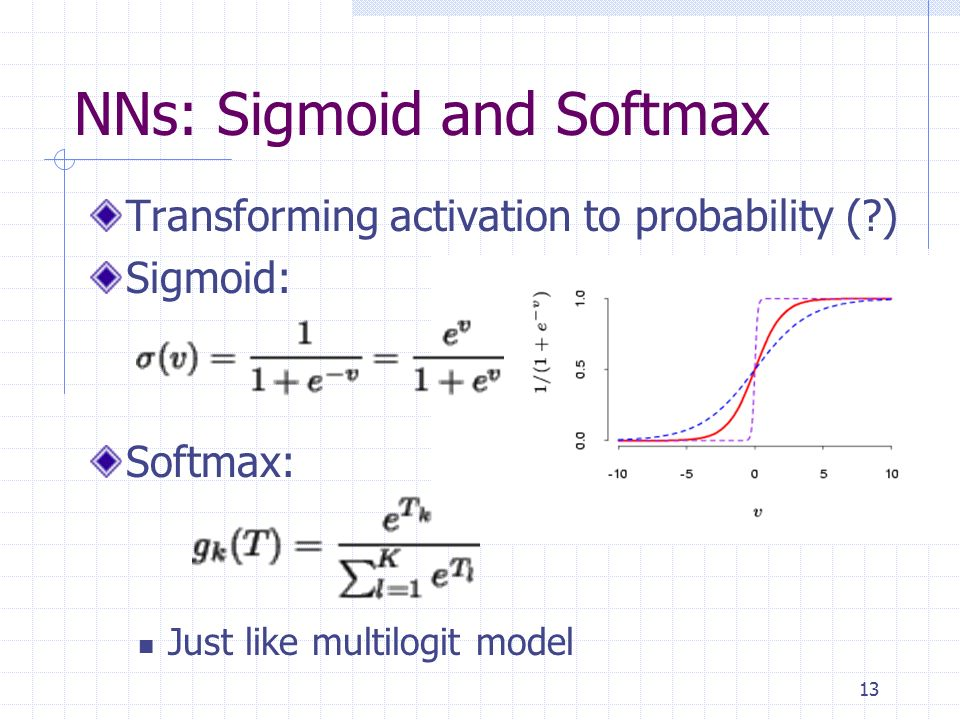

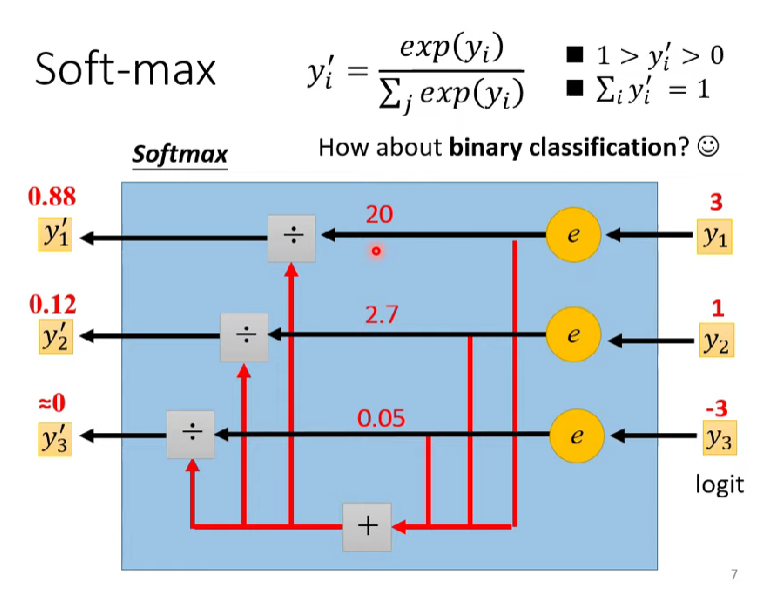

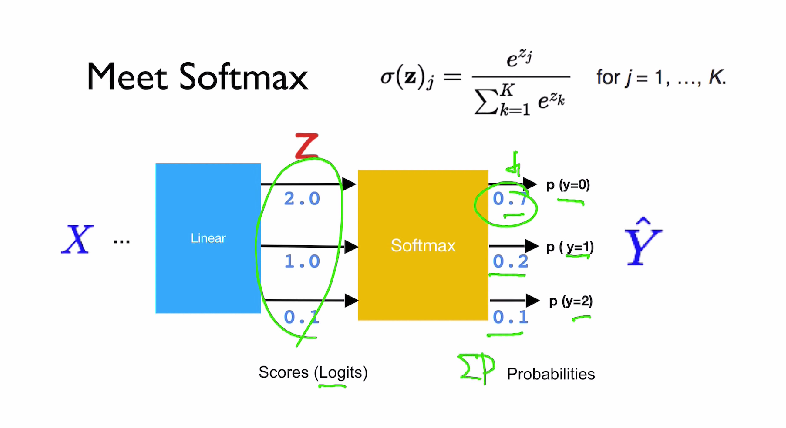

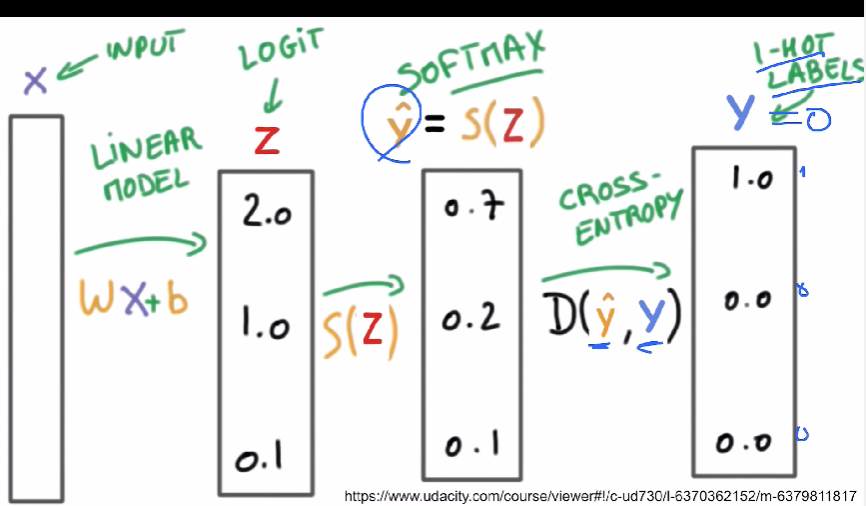

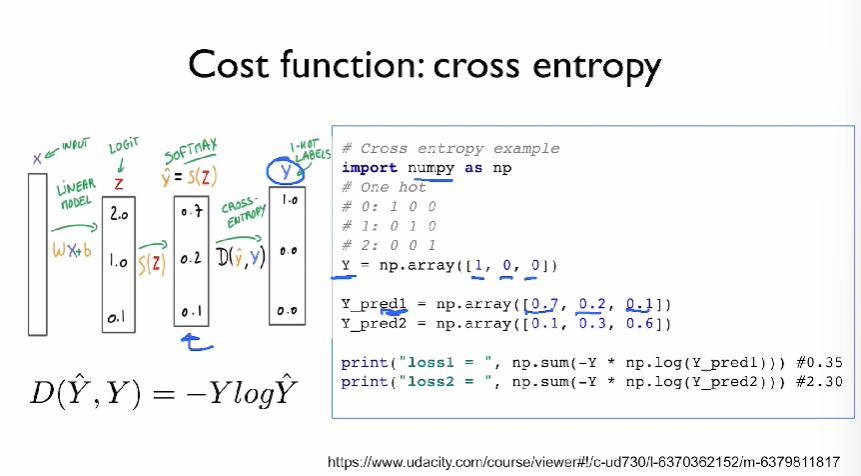

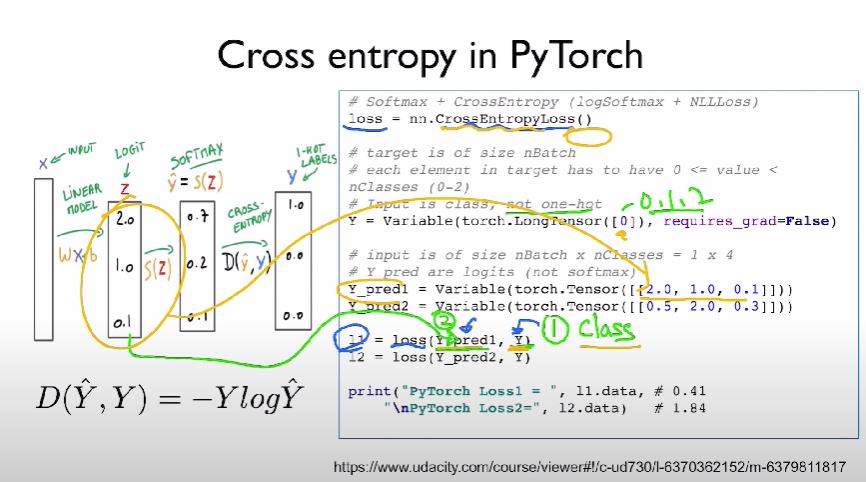

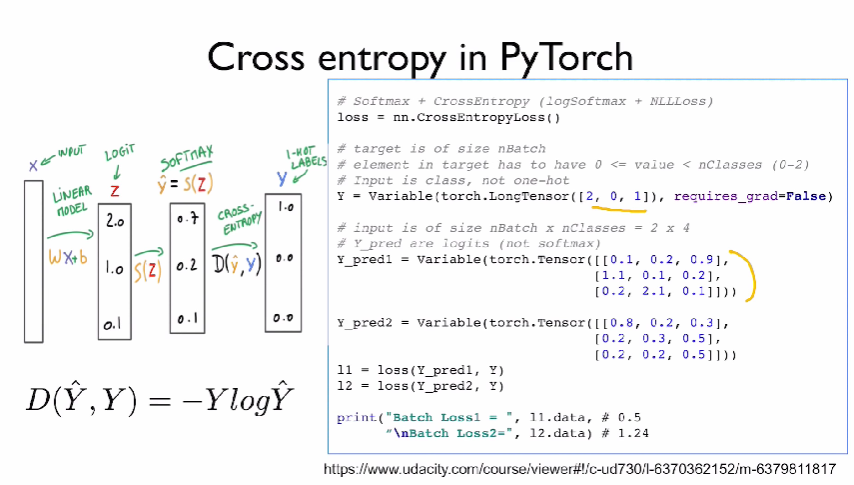

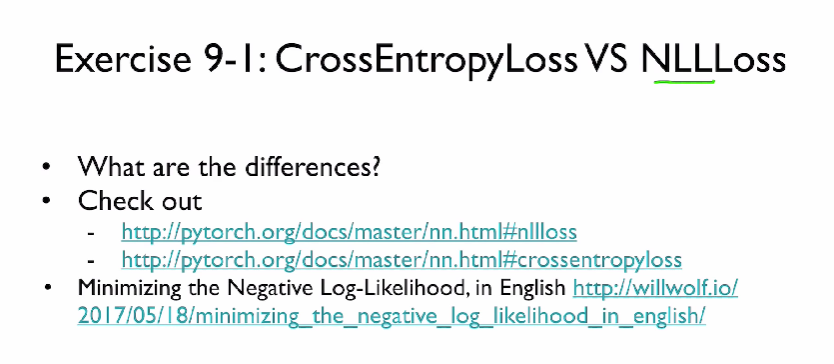

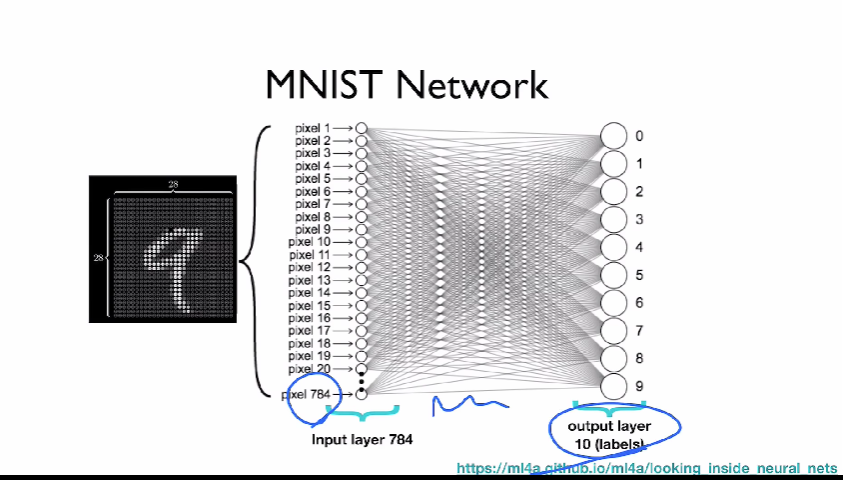

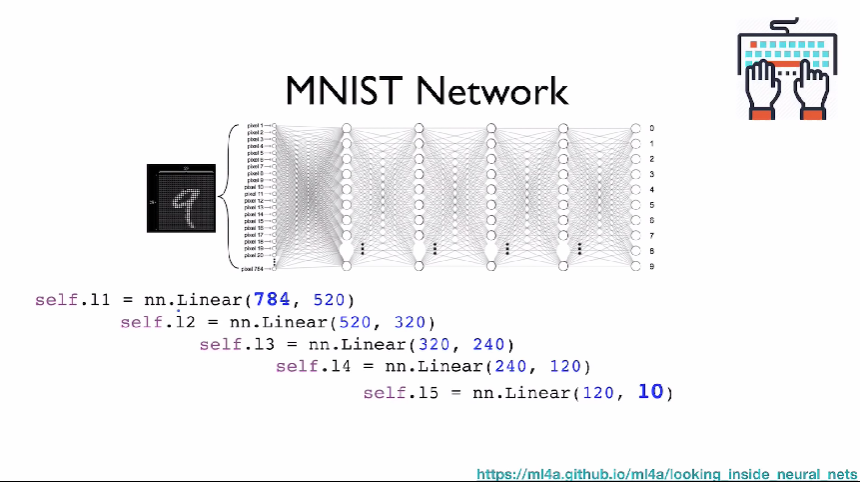

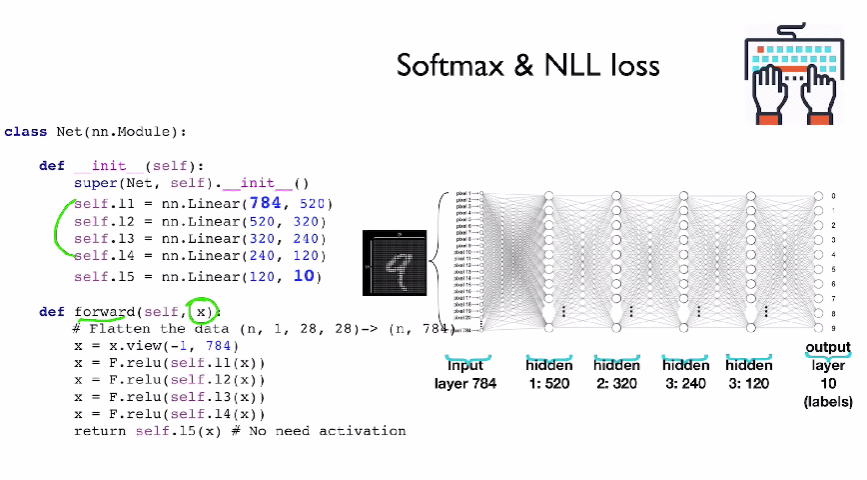

斜體文字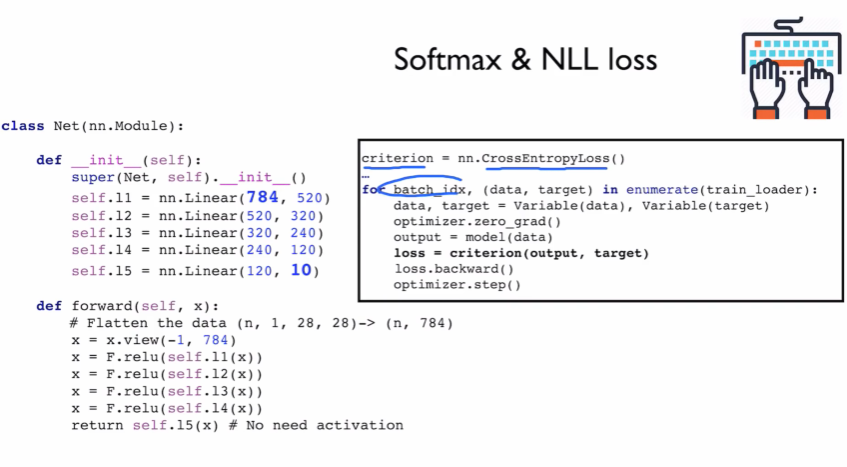

In [1]:
from torch import nn, tensor, max
import numpy as np

# Cross entropy example
# One hot
# 0: 1 0 0
# 1: 0 1 0
# 2: 0 0 1
Y = np.array([1, 0, 0])
Y_pred1 = np.array([0.7, 0.2, 0.1])
Y_pred2 = np.array([0.1, 0.3, 0.6])
print(f'Loss1: {np.sum(-Y * np.log(Y_pred1)):.4f}')
print(f'Loss2: {np.sum(-Y * np.log(Y_pred2)):.4f}')

# Softmax + CrossEntropy (logSoftmax + NLLLoss)
loss = nn.CrossEntropyLoss()

# target is of size nBatch
# each element in target has to have 0 <= value < nClasses (0-2)
# Input is class, not one-hot
Y = tensor([0], requires_grad=False)

# input is of size nBatch x nClasses = 1 x 4
# Y_pred are logits (not softmax)
Y_pred1 = tensor([[2.0, 1.0, 0.1]])
Y_pred2 = tensor([[0.5, 2.0, 0.3]])

l1 = loss(Y_pred1, Y)
l2 = loss(Y_pred2, Y)

print(f'PyTorch Loss1: {l1.item():.4f} \nPyTorch Loss2: {l2.item():.4f}')
print(f'Y_pred1: {max(Y_pred1.data, 1)[1].item()}')
print(f'Y_pred2: {max(Y_pred2.data, 1)[1].item()}')

# target is of size nBatch
# each element in target has to have 0 <= value < nClasses (0-2)
# Input is class, not one-hot
Y = tensor([2, 0, 1], requires_grad=False)

# input is of size nBatch x nClasses = 2 x 4
# Y_pred are logits (not softmax)
Y_pred1 = tensor([[0.1, 0.2, 0.9],
          [1.1, 0.1, 0.2],
          [0.2, 2.1, 0.1]])

Y_pred2 = tensor([[0.8, 0.2, 0.3],
          [0.2, 0.3, 0.5],
          [0.2, 0.2, 0.5]])

l1 = loss(Y_pred1, Y)
l2 = loss(Y_pred2, Y)
print(f'Batch Loss1:  {l1.item():.4f} \nBatch Loss2: {l2.data:.4f}')

Loss1: 0.3567
Loss2: 2.3026
PyTorch Loss1: 0.4170 
PyTorch Loss2: 1.8406
Y_pred1: 0
Y_pred2: 1
Batch Loss1:  0.4966 
Batch Loss2: 1.2389


In [1]:
from __future__ import print_function
from torch import nn, optim, cuda
from torch.utils import data
from torchvision import datasets, transforms
import torch.nn.functional as F
import time

# Training settings
batch_size = 64
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Training MNIST Model on {device}\n{"=" * 44}')

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 520)
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)


model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')


if __name__ == '__main__':
    since = time.time()
    for epoch in range(1, 10):
        epoch_start = time.time()
        train(epoch)
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Training time: {m:.0f}m {s:.0f}s')
        test()
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Testing time: {m:.0f}m {s:.0f}s')

    m, s = divmod(time.time() - since, 60)
    print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

Training MNIST Model on cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Train Epoch: 1 | Batch Status: 0/60000 (0%) | Loss: 2.298346
Train Epoch: 1 | Batch Status: 640/60000 (1%) | Loss: 2.307626
Train Epoch: 1 | Batch Status: 1280/60000 (2%) | Loss: 2.307920
Train Epoch: 1 | Batch Status: 1920/60000 (3%) | Loss: 2.303835
Train Epoch: 1 | Batch Status: 2560/60000 (4%) | Loss: 2.292394
Train Epoch: 1 | Batch Status: 3200/60000 (5%) | Loss: 2.294620
Train Epoch: 1 | Batch Status: 3840/60000 (6%) | Loss: 2.318727
Train Epoch: 1 | Batch Status: 4480/60000 (7%) | Loss: 2.304697
Train Epoch: 1 | Batch Status: 5120/60000 (9%) | Loss: 2.302109
Train Epoch: 1 | Batch Status: 5760/60000 (10%) | Loss: 2.295233
Train Epoch: 1 | Batch Status: 6400/60000 (11%) | Loss: 2.296109
Train Epoch: 1 | Batch Status: 7040/60000 (12%) | Loss: 2.294244
Train Epoch: 1 | Batch Status: 7680/60000 (13%) | Loss: 2.303666
Train Epoch: 1 | Batch Status: 8320/60000 (14%) | Loss: 2.297903
Train Epoch: 1 |